# Pan005 Mid Depth Temperature

In [1]:
import gsw
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe


import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.path as mpath

## Commented out by Jemma; I wanted to make sure if anything funky showed up I was told about it
import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1,memory_limit=0)
client.amm.start()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35459/status,
Dashboard: /proxy/35459/status,Workers: 28
Total threads: 28,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40349,Workers: 28
Dashboard: /proxy/35459/status,Total threads: 28
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36563,Total threads: 1
Dashboard: /proxy/45649/status,Memory: 0 B
Nanny: tcp://127.0.0.1:39747,


In [3]:
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/outpu*/*.ocean_month_z.nc'))[120:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/outpu*/*.ocean_month_z.nc'))[:60]

In [4]:
## Creating shelf mask another way

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [5]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_005')

In [6]:
#Time variant variables
def preprocess(ds):
    ds = ds[['thetao', 'volcello','so']].sel(yh=slice(None,-55)).sel(z_l=slice(400,600))
    return ds

cont = xr.open_mfdataset(pathsC,
                         preprocess = preprocess,
                         #chunks='auto',
                         chunks = {'time':1,'z_l':38,'yh':564,'xh':600},
                         decode_times=True,
                         decode_timedelta=False,
                         parallel=True,
                         # compat='override',
                         # coords='minimal',
                        )
melt = xr.open_mfdataset(pathsM,
                         preprocess = preprocess,
                         #chunks='auto',
                         chunks = {'time':1,'z_l':38,'yh':564,'xh':600},
                         decode_times=True,
                         decode_timedelta=False,
                         parallel=True,
                         # compat='override',
                         # coords='minimal',
                        )

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/utils.py:77: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  return func(*args, **kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/utils.py:77: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  return func(*args, **kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/utils.py:77: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  return func(*args, **kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04

In [7]:
#Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [8]:
#Time invariant variables
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['deptho']
areaC = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/output120/20010101.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])

#### Time mean for mapping

In [9]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont['z_l'], cont['yh'])
p_melt = gsw.p_from_z(-melt['z_l'], melt['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont['so'], p_cont, cont['xh'], cont['yh'])
SA_melt =  gsw.SA_from_SP(melt['so'], p_melt, melt['xh'], melt['yh'])

# Calculating conservative temperature
tempC = gsw.CT_from_pt(SA_cont,cont['thetao'])
tempM = gsw.CT_from_pt(SA_melt,melt['thetao'])

# To fix the label issues
tempC = xr.DataArray(tempC, dims=cont['thetao'].dims, coords=cont['thetao'].coords)
tempC.attrs['units'] = '°C'
tempC.name = 'CT'

tempM = xr.DataArray(tempM, dims=melt['thetao'].dims, coords=melt['thetao'].coords)
tempM.attrs['units'] = '°C'
tempM.name = 'CT'

In [10]:
tempC

<xarray.DataArray 'CT' (time: 120, z_l: 4, yh: 1166, xh: 7200)> Size: 32GB
dask.array<ct_from_pt, shape=(120, 4, 1166, 7200), dtype=float64, chunksize=(1, 3, 564, 600), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 9kB -81.1 -81.08 -81.06 ... -55.08 -55.05 -55.02
  * z_l      (z_l) float64 32B 423.7 468.4 517.6 571.6
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:          °C
    long_name:      Sea Water Salinity
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity

In [ ]:
tempC = tempC.astype('float32').load()
tempM = tempM.astype('float32').load()

2025-09-21 15:37:32,087 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('getitem-open_dataset-thetao-concatenate-0ed0c4a84ed8f09c25496b85dafa22f8', 74, 1, 1, 0))" coro=<Worker.execute() done, defined at /g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/worker_state_machine.py:3607>> ended with CancelledError
2025-09-21 15:37:32,090 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('astype-3edf23a3f16cddc3ab582fae5d07a1b6', 72, 1, 1, 8))" coro=<Worker.execute() done, defined at /g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/worker_state_machine.py:3607>> ended with CancelledError
2025-09-21 15:37:32,119 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('getitem-open_dataset-so-concatenate-52125fe575e7f249908027ad9bfcba92', 74, 1, 1, 0))" coro

In [ ]:
tempC.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/midtemp_tempC_pan005.nc')
tempM.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/midtemp_tempM_pan005.nc')

#### Taking the depth mean

In [9]:
volC = cont['volcello']
volM = melt['volcello']
volC

<xarray.DataArray 'volcello' (time: 120, z_l: 4, yh: 1166, xh: 7200)> Size: 16GB
dask.array<concatenate, shape=(120, 4, 1166, 7200), dtype=float32, chunksize=(1, 3, 564, 600), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 9kB -81.1 -81.08 -81.06 ... -55.08 -55.05 -55.02
  * z_l      (z_l) float64 32B 423.7 468.4 517.6 571.6
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:          m3
    long_name:      Ocean grid-cell volume
    cell_methods:   area:sum z_l:sum yh:sum xh:sum time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  ocean_volume

In [10]:
# Correcting area 
saltC = cont['so']
saltM = melt['so']

areaC_corr = areaC*(saltC.isel(time=0,z_l=0)*0 +1)
areaM_corr = areaM*(saltM.isel(time=0,z_l=0)*0 +1)

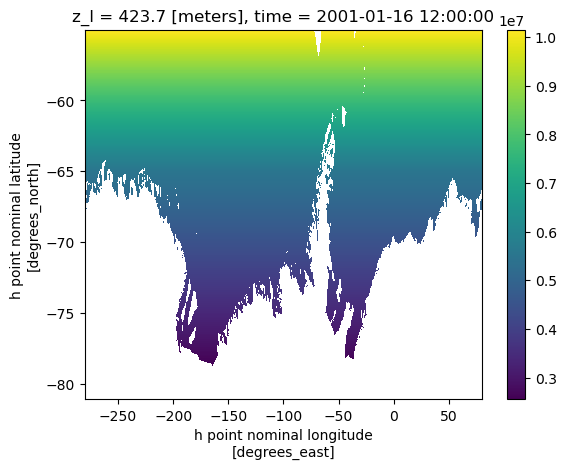

In [11]:
areaC_corr.plot()

In [12]:
thikC = volC / areaC_corr
thikM = volM / areaM_corr

In [13]:
tempC = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/midtemp_tempC_pan005.nc',chunks = {'time':1,'z_l':38,'yh':564,'xh':600})
tempM = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/midtemp_tempM_pan005.nc',chunks = {'time':1,'z_l':38,'yh':564,'xh':600})

In [14]:
tempC

<xarray.DataArray 'CT' (time: 120, z_l: 4, yh: 1166, xh: 7200)> Size: 16GB
dask.array<open_dataset-CT, shape=(120, 4, 1166, 7200), dtype=float32, chunksize=(1, 4, 564, 600), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 9kB -81.1 -81.08 -81.06 ... -55.08 -55.05 -55.02
  * z_l      (z_l) float64 32B 423.7 468.4 517.6 571.6
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:          °C
    long_name:      Sea Water Salinity
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity

In [15]:
# Depth average
tempC_mid = (thikC * tempC).sum(['z_l']) / thikC.sum(['z_l'])
tempM_mid = (thikM * tempM).sum(['z_l']) / thikM.sum(['z_l'])

In [16]:
tempC_mid

<xarray.DataArray (time: 120, yh: 1166, xh: 7200)> Size: 4GB
dask.array<truediv, shape=(120, 1166, 7200), dtype=float32, chunksize=(1, 564, 600), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 9kB -81.1 -81.08 -81.06 ... -55.08 -55.05 -55.02
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00

### Plotting

In [17]:
tempC_mid_map = tempC_mid.sel(time=slice('2006-01-01','2010-12-31')).mean(dim='time')
tempM_mid_map = tempM_mid.sel(time=slice('2006-01-01','2010-12-31')).mean(dim='time')

In [18]:
tempC_mid_map

<xarray.DataArray (yh: 1166, xh: 7200)> Size: 34MB
dask.array<mean_agg-aggregate, shape=(1166, 7200), dtype=float32, chunksize=(564, 600), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 9kB -81.1 -81.08 -81.06 ... -55.08 -55.05 -55.02

In [19]:
tempC_mid_map = tempC_mid_map.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_c

In [20]:
tempM_mid_map = tempM_mid_map.load()

In [21]:
temp_anom_mid_map = tempM_mid_map - tempC_mid_map
temp_anom_mid_map = temp_anom_mid_map.load()

In [22]:
temp_anom_mid_map

<xarray.DataArray (yh: 1166, xh: 7200)> Size: 34MB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.02199686, 0.02347159, 0.02330399, ..., 0.01617944, 0.01785171,
        0.02000308],
       [0.02259576, 0.02350998, 0.02269495, ..., 0.0165956 , 0.01855087,
        0.02057719],
       [0.0230999 , 0.02347803, 0.02204084, ..., 0.01773608, 0.01965737,
        0.02145135]], dtype=float32)
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 9kB -81.1 -81.08 -81.06 ... -55.08 -55.05 -55.02

In [ ]:
temp_anom_mid.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/mid_temp_map_Pan005.nc')

In [24]:
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
projection = ccrs.SouthPolarStereo()

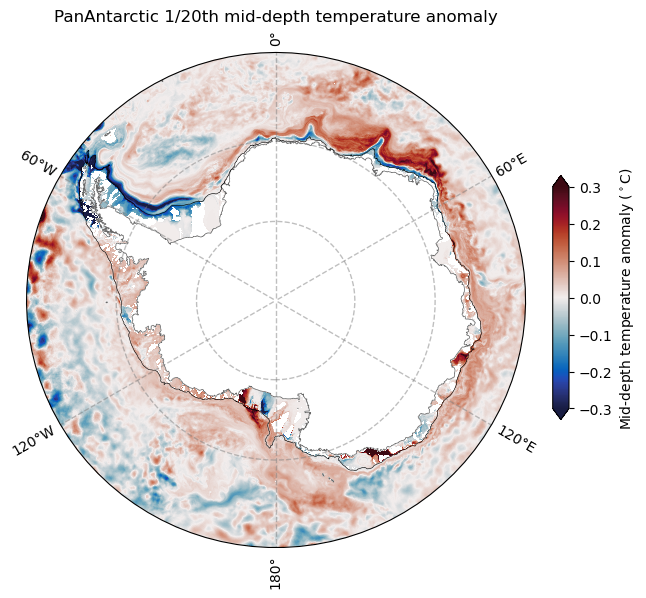

In [25]:
# With conservative temperature

projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.4,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
temp_anom_mid_map.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.3,
    vmax=0.3,
    extend="both",
    cmap= cm.cm.balance,
    cbar_kwargs={"label": "Mid-depth temperature anomaly ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("PanAntarctic 1/20th mid-depth temperature anomaly");

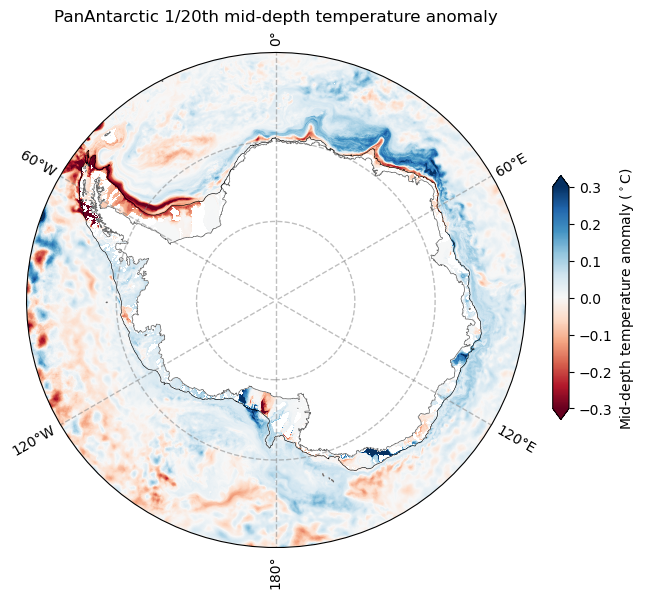

In [26]:
# With conservative temperature

projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.4,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
temp_anom_mid_map.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.3,
    vmax=0.3,
    extend="both",
    cmap= 'RdBu', #cm.cm.balance
    cbar_kwargs={"label": "Mid-depth temperature anomaly ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("PanAntarctic 1/20th mid-depth temperature anomaly");

## Time series

In [27]:
# Just shelf 
tempC_shelf = tempC_mid.where(shelf_mask == 1)
tempM_shelf = tempM_mid.where(shelf_mask == 1)

In [30]:
# Spatial average
tempC_time = (areaC_corr * tempC_shelf).sum(['xh', 'yh']) / areaC_corr.sum(['xh', 'yh'])
tempM_time = (areaM_corr * tempM_shelf).sum(['xh', 'yh']) / areaM_corr.sum(['xh', 'yh'])

In [32]:
tempC_time = tempC_time.load()

In [33]:
tempM_time = tempM_time.load()

Text(0.5, 1.0, 'PanAn 1/20th Time Series of Mid-depth Temperature on Shelf')

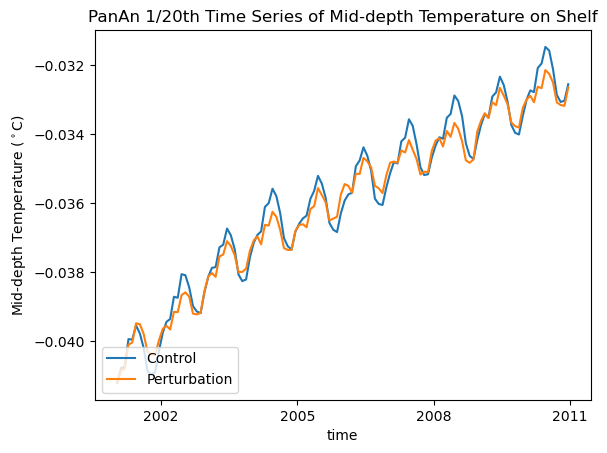

In [34]:
tempC_time.plot(label="Control")
tempM_time.plot(label="Perturbation")
plt.ylabel("Mid-depth Temperature ($^\circ$C)")
plt.legend(loc="lower left")
plt.title("PanAn 1/20th Time Series of Mid-depth Temperature on Shelf")

In [35]:
midtemp_anom_time = tempM_time - tempC_time
midtemp_anom_time = midtemp_anom_time.load()

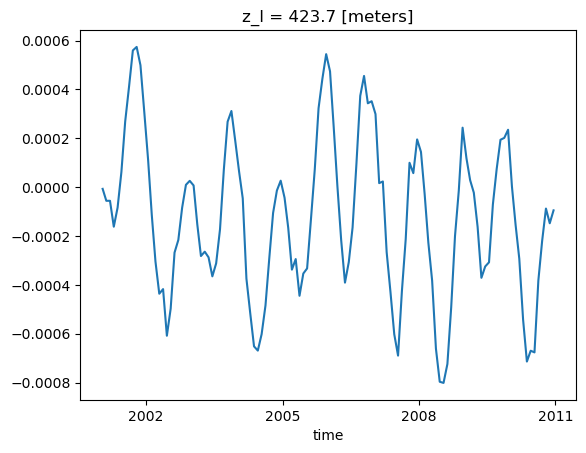

In [36]:
midtemp_anom_time.plot()

In [37]:
midtemp_anom_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/midtemp_anom_CT_pan005.nc')

## Comparison of the PanAns

In [3]:
pan005_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/midtemp_anom_CT_pan005.nc', chunks = 'auto')
pan01_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/midtemp_anom_CT_pan01.nc', chunks = 'auto')
#acc_bottemp_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_access.nc', chunks = 'auto')

In [4]:
pan005_anom_new = pan005_anom.to_series()
pan01_anom_new = pan01_anom.to_series()

In [5]:
import pandas as pd

In [6]:
# Slice 1910–1919 and 2001–2010
pan005_anom_new = pan005_anom_new['2001-01-01':'2010-10-16']
pan01_anom_new = pan01_anom_new['2001-01-01':'2010-10-16']
#acc_bottemp_anom_new = acc_bottemp_anom_new['1910-01-16':'1919-12-16']

# Reset index to normalized months
pan005_anom_new.index = range(0, len(pan005_anom_new))
pan01_anom_new.index = range(0, len(pan01_anom_new))
#acc_bottemp_anom_new.index = range(1, len(acc_bottemp_anom_new)+1)

In [7]:
pan005_anom_new = pan005_anom_new.reset_index(drop=True)
pan01_anom_new = pan01_anom_new.reset_index(drop=True)

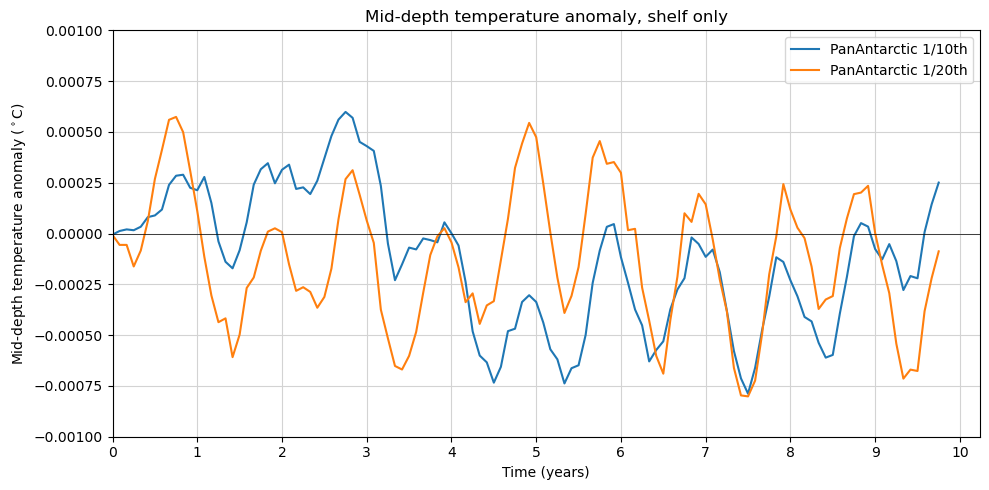

In [8]:
# Make month index start at 0
pan01_anom_new.index = range(len(pan01_anom_new))
pan005_anom_new.index = range(len(pan005_anom_new))

plt.figure(figsize=(10, 5))
plt.plot(pan01_anom_new.index, pan01_anom_new.values, label='PanAntarctic 1/10th')
plt.plot(pan005_anom_new.index, pan005_anom_new.values, label='PanAntarctic 1/20th')

# X-axis: ticks every 12 months, labeled as years from 0 to 10
plt.xticks(ticks=range(0, 121, 12), labels=[str(i) for i in range(0, 11)])

plt.xlabel('Time (years)')
plt.ylabel("Mid-depth temperature anomaly ($^\circ$C)")
plt.title('Mid-depth temperature anomaly, shelf only')
plt.ylim(-0.001, 0.001)
plt.xlim(0,None)
plt.legend()
plt.grid(True, color='lightgrey')
plt.axhline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()